In [1]:
#https://www.kaggle.com/lkuffo/exploratory-data-analysis-w-python
#http://brandonrose.org/clustering
#pip install wordcloud
#pip install mpld3

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import mpld3

nltk.download('stopwords')
nltk.download('punkt')
#import re
#import seaborn as sns
#import string
#import html
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
#from datetime import datetime
#from sklearn.preprocessing import normalize, MinMaxScaler
#from scipy.stats import spearmanr, pearsonr
#from nltk.corpus import stopwords
#from wordcloud import WordCloud, STOPWORDS
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all" # To see all the outputs in the notebook, not only the last one
#pd.set_option('display.max_colwidth', -1) # To see all text in reviews

#plt.style.use('ggplot')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ab.gupta1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ab.gupta1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Reading data 
drugs = pd.read_csv("data/drugsComTrain_raw.csv")
drugs.head()

,ID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [3]:
drugs.shape

(161297, 7)

In [4]:
# Let's delete all of these corrupted rows
corrupted_rows = drugs.condition.str.contains(" users found this comment helpful.", na=False)

print("Number of Corrupted Reviews: ", len(drugs[corrupted_rows]))
drugs = drugs[~corrupted_rows]

Number of Corrupted Reviews:  900


In [5]:
# A basic descriptive analysis of the data 
drugs.describe() 

,ID,rating,usefulCount
count,160397.000000,160397.000000,160397.000000
mean,115916.727595,6.995586,28.098425
std,66986.583051,3.272543,36.458217
min,2.000000,1.000000,0.000000
25%,58080.000000,5.000000,6.000000
50%,115719.000000,8.000000,16.000000
75%,173753.000000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


In [6]:
#Groups of drugs
print("Number of Reviews per Drug")

# Number of reviews per drug
reviews_per_drug = drugs.groupby(["drugName"]).agg({
    "ID": pd.Series.nunique
})
reviews_per_drug.describe()

Number of Reviews per Drug


,ID
count,3417.000000
mean,46.940884
std,164.755503
min,1.000000
25%,2.000000
50%,5.000000
75%,26.000000
max,3657.000000


In [7]:
print("Number of Reviews per Condition")
# Number of reviews per condition
reviews_per_condition = drugs.groupby(["condition"]).agg({
    "ID": pd.Series.nunique
})

reviews_per_condition.describe()

Number of Reviews per Condition


,ID
count,811.000000
mean,196.668311
std,1183.429718
min,1.000000
25%,3.000000
50%,10.000000
75%,64.500000
max,28788.000000


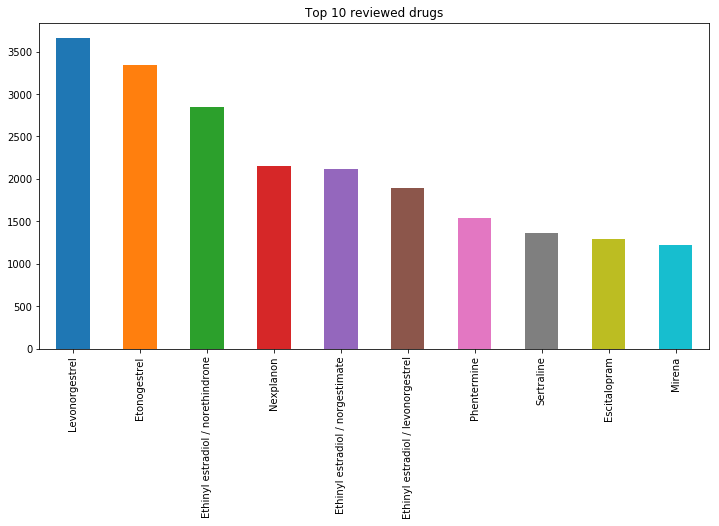

In [8]:
# Top 10 most reviewed drug names

plot = drugs.drugName.value_counts().nlargest(10).plot(kind='bar', title="Top 10 reviewed drugs", figsize=(12,6))

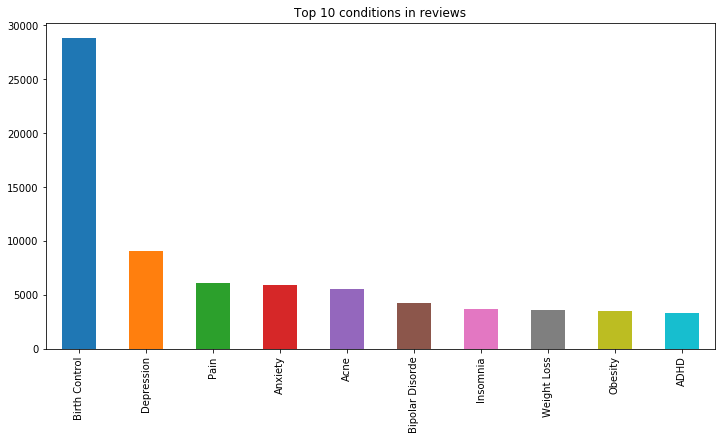

In [9]:
# Top 10 most suffered condition by reviewers
plot = drugs.condition.value_counts().nlargest(10).plot(kind='bar', title="Top 10 conditions in reviews", figsize=(12,6))

In [10]:
drugs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160397 entries, 0 to 161296
Data columns (total 7 columns):
ID             160397 non-null int64
drugName       160397 non-null object
condition      159498 non-null object
review         160397 non-null object
rating         160397 non-null int64
date           160397 non-null object
usefulCount    160397 non-null int64
dtypes: int64(3), object(4)
memory usage: 9.8+ MB


In [11]:
drugs.isnull().any()

ID             False
drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
dtype: bool

In [12]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

# check to see stopwards were imported
print(stopwords[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [13]:
# load nltk's SnowballStemmer as variabled 'stemmer'
# Stemming breaks down the word to its root
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [47]:
# Using generators instead of list

def tokenize(text):
    tokens = (
        word.lower()
        for sent in nltk.sent_tokenize(text)
        for word in nltk.word_tokenize(sent)
        if re.search('[a-zA-Z]', word)
        if word.lower() not in stopwords
    )
    return tokens

In [48]:
# Using generators instead of list

def tokenize_and_stem(text):
    return (stemmer.stem(t) for t in tokenize(text))

In [16]:
# drugs.review.head()
len(drugs.review)
# type(drugs.review)

160397

In [49]:
%time totalvocab_stemmed = drugs.review.apply(tokenize_and_stem)

CPU times: user 32.7 s, sys: 104 ms, total: 32.8 s
Wall time: 32.8 s


In [18]:
# totalvocab_stemmed = [li for el in totalvocab_stemmed for li in el]
len(totalvocab_stemmed)

160397

In [19]:
%time totalvocab_tokenized = drugs.review.apply(tokenize)

CPU times: user 33.8 s, sys: 240 ms, total: 34 s
Wall time: 34 s


In [20]:
len(totalvocab_tokenized)
# totalvocab_tokenized = [li for el in totalvocab_tokenized for li in el]

160397

In [21]:
vocab_frame = pd.DataFrame({'words': [li for el in totalvocab_tokenized for li in el]}, 
                           index = [li for el in totalvocab_stemmed for li in el])

KeyboardInterrupt: 

In [22]:
vocab_frame = pd.DataFrame({'words': list(totalvocab_tokenized)},
                           index = list(totalvocab_stemmed))

In [23]:
vocab_frame.head()

,words
<generator object tokenize_and_stem.<locals>.<genexpr> at 0x7fc89981b518>,<generator object tokenize.<locals>.<genexpr> ...
<generator object tokenize_and_stem.<locals>.<genexpr> at 0x7fc89981b5c8>,<generator object tokenize.<locals>.<genexpr> ...
<generator object tokenize_and_stem.<locals>.<genexpr> at 0x7fc89981b6d0>,<generator object tokenize.<locals>.<genexpr> ...
<generator object tokenize_and_stem.<locals>.<genexpr> at 0x7fc89981b7d8>,<generator object tokenize.<locals>.<genexpr> ...
<generator object tokenize_and_stem.<locals>.<genexpr> at 0x7fc89981b8e0>,<generator object tokenize.<locals>.<genexpr> ...


In [24]:
# Save vocab_frame in a pickle file named as vocab_frame
import pickle

def save_as_pickle(filename, df):
    print("Saving dataframe in a pickle file: %s" % filename)
    obj = open(filename, 'wb')
    pickle.dump(df, obj)
    obj.close()

In [25]:
def load_data(filename):
    print("Retrieving data from: %s" % filename)
    with open(filename, 'rb') as fout:
        data = pickle.load(fout)
    return data

In [26]:
print('There are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

There are 160397 items in vocab_frame


In [ ]:
# # define vectorizer parameters
# tfidf_vectorizer = TfidfVectorizer(max_df=0.8, 
#                                    max_features=200000,
#                                    min_df=0.2, 
#                                    stop_words='english',
#                                    use_idf=True,
#                                    tokenizer=tokenize_and_stem,
#                                    ngram_range=(1,3))

In [61]:
%time totalvocab_stemmed = drugs.review.apply(tokenize_and_stem)
%time totalvocab_stemmed_list = [list(el) for el in totalvocab_stemmed]

CPU times: user 32.7 s, sys: 60 ms, total: 32.8 s
Wall time: 32.8 s
CPU times: user 4min 30s, sys: 272 ms, total: 4min 31s
Wall time: 4min 31s


In [62]:
# define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, 
                                   max_features=200000,                                                                  
                                   use_idf=True,           
                                   
                                   ngram_range=(1,3))

In [63]:
len(totalvocab_stemmed_list)
totalvocab_stemmed_list[:10]

[['side', 'effect', 'take', 'combin', 'bystol', 'mg', 'fish', 'oil'],
 ['son',
  'halfway',
  'fourth',
  'week',
  'intuniv',
  'becam',
  'concern',
  'began',
  'last',
  'week',
  'start',
  'take',
  'highest',
  'dose',
  'two',
  'day',
  'could',
  'hard',
  'get',
  'bed',
  'cranki',
  'slept',
  'near',
  'hour',
  'drive',
  'home',
  'school',
  'vacat',
  'unusu',
  'call',
  'doctor',
  'monday',
  'morn',
  'said',
  'stick',
  'day',
  'see',
  'school',
  'get',
  'morn',
  'last',
  'two',
  'day',
  'problem',
  'free',
  'much',
  'agreeabl',
  'ever',
  'less',
  'emot',
  'good',
  'thing',
  'less',
  'cranki',
  'rememb',
  'thing',
  'overal',
  'behavior',
  'better',
  'tri',
  'mani',
  'differ',
  'medic',
  'far',
  'effect'],
 ['use',
  'take',
  'anoth',
  'oral',
  'contracept',
  'pill',
  'cycl',
  'happy-',
  'light',
  'period',
  'max',
  'day',
  'side',
  'effect',
  'contain',
  'hormon',
  'gestoden',
  'avail',
  'us',
  'switch',
  'lybrel',

In [64]:
# fit the vectorizer to synopses
# %time tfidf_matrix = tfidf_vectorizer.fit_transform(drugs.review)
%time tfidf_matrix = tfidf_vectorizer.fit_transform(totalvocab_stemmed_list)

print(tfidf_matrix.shape)

AttributeError: 'list' object has no attribute 'lower'

(6462709, 53876)


In [38]:
type(tfidf_matrix)
# print(tfidf_matrix)

scipy.sparse.csr.csr_matrix

In [42]:
tfidf_matrix.shape
# tfidf_matrix.indices

(13564600, 53893)

In [40]:
#Vocab matrix
terms = tfidf_vectorizer.get_feature_names()

## Need to break Matrix up into several

In [41]:
#Calculating distances
%time
dist1 = 1 - cosine_similarity(X=tfidf_matrix[0:2], Y=tfidf_matrix)
dist2 = 1 - cosine_similarity(X=tfidf_matrix[2:4], Y=tfidf_matrix)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.7 µs


## Append broken matrix up into one

In [ ]:
np.append(dist1, dist2, axis=0)

In [ ]:
tfidf_matrix